In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from scipy.ndimage import rotate
import cv2 
import random 

import torch
from torch import tensor
import torch.nn as nn
relu = nn.functional.relu
softmax = nn.functional.softmax
from torch.nn.functional import cross_entropy
from pathlib import Path
import os, shutil
from os import listdir
import pickle

<class 'numpy.ndarray'>
(470, 1000, 4)
(420, 950, 4)


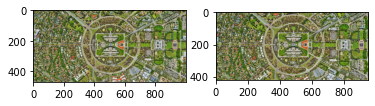

In [42]:
im = Image.open(r"C:\Users\g_bab\Downloads\aerial.png")
#just make the image we send in a square and we'll figure out what dims to break the smaller things into
im = np.array(im)
im_small = im[25:-25, 25:-25]       #will use this when adding bits and pieces to the images x and y, assuming 25 is the amount we are shifting along x or y - prevents out of bounds
print(type(im))
print(im.shape)
print(im_small.shape)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(im_small)

In [4]:
#zoom 
def clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [43]:
#base square size
M, N = 100, 100

In [44]:
randomadd = random.randint(-25,25)
randomsubtract = random.randint(-25,25)
print(randomadd, randomsubtract)

-2 25


In [45]:
rangex = range(0, im_small.shape[0], M)
rangey = range(0,im_small.shape[1],N)

tiles = [im[x:x+M,y:y+N] for x in rangex for y in rangey]

sized_tiles = [im[x+randomsubtract:x+M+randomadd, y+randomsubtract:y+N+randomadd] for x in rangex for y in rangey]

labels = range(len(tiles))
print(len(labels))
print(len(sized_tiles))

50
50


<ipython-input-54-7c992e28064c>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2)


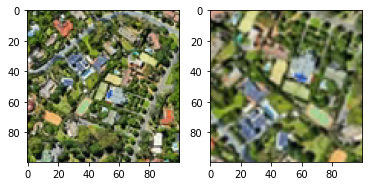

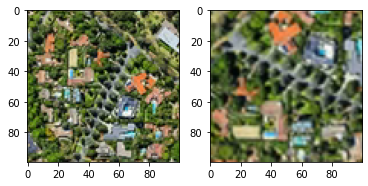

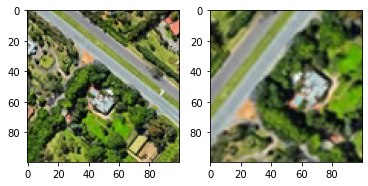

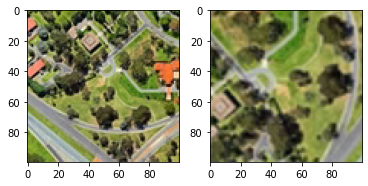

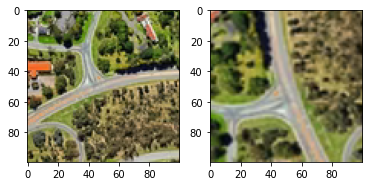

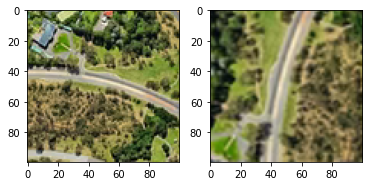

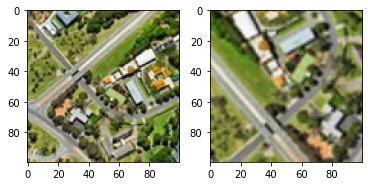

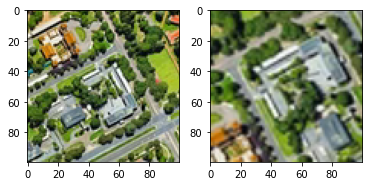

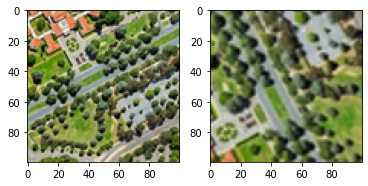

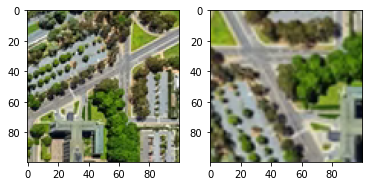

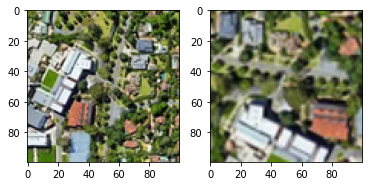

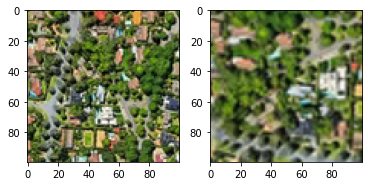

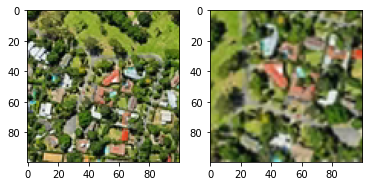

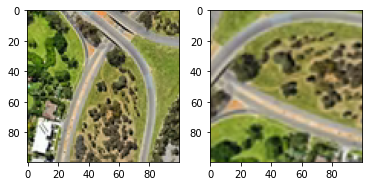

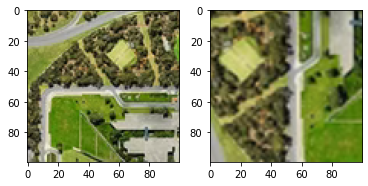

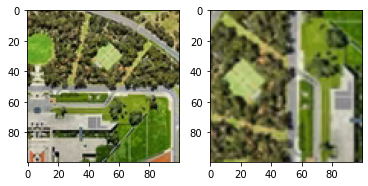

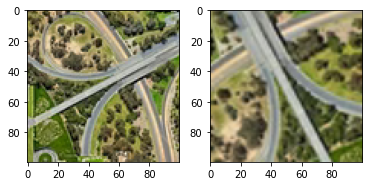

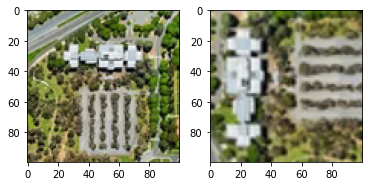

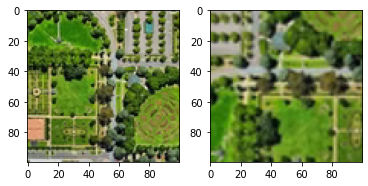

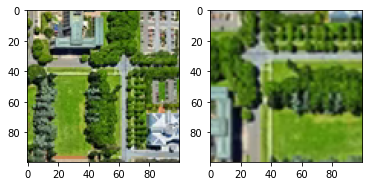

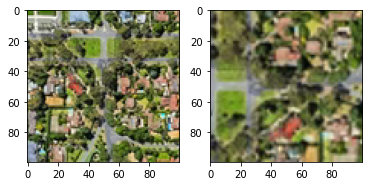

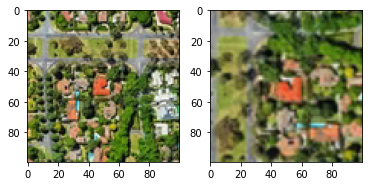

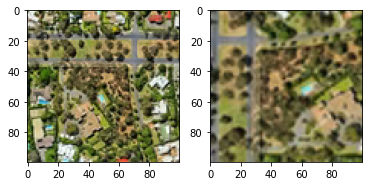

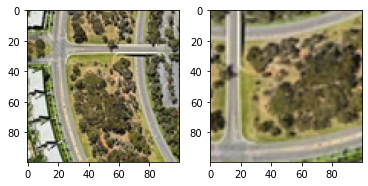

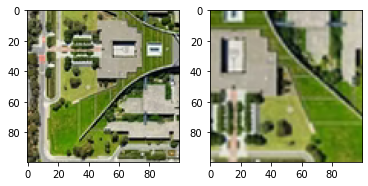

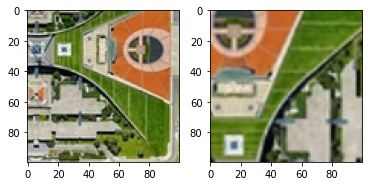

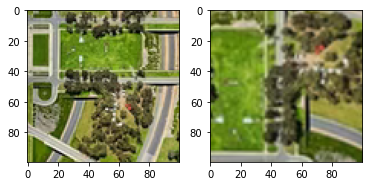

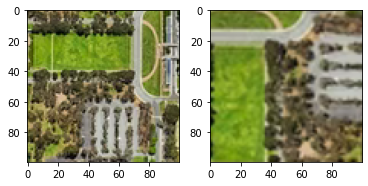

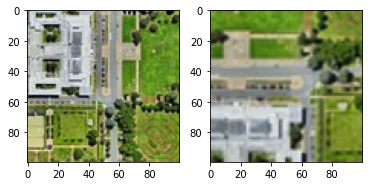

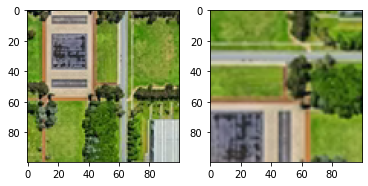

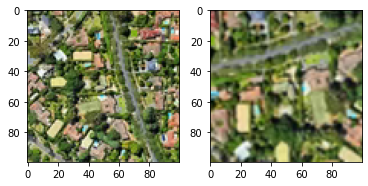

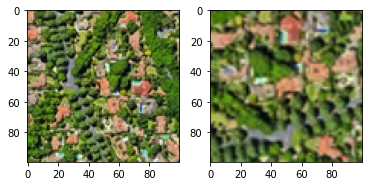

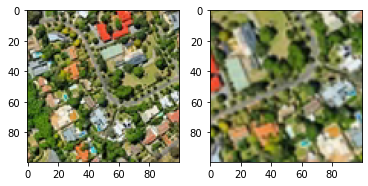

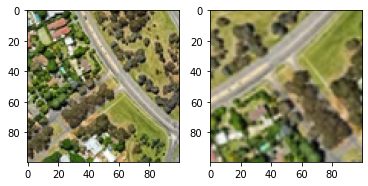

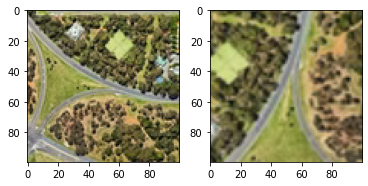

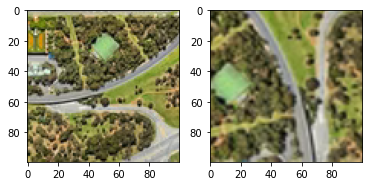

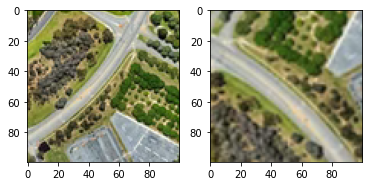

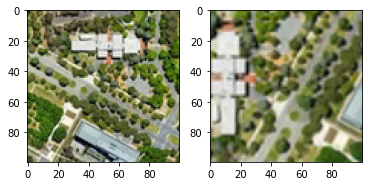

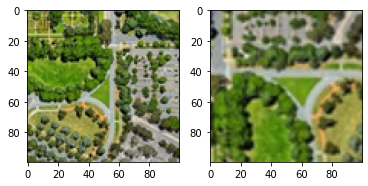

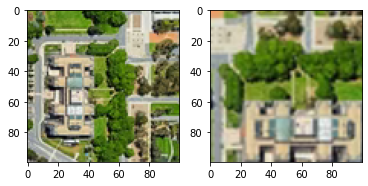

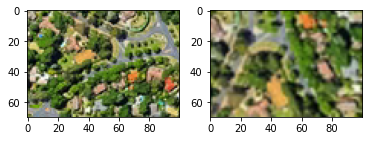

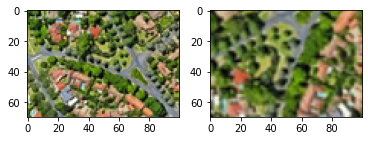

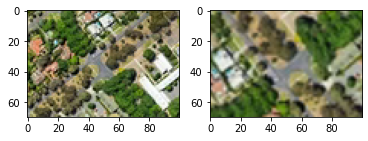

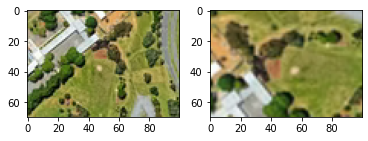

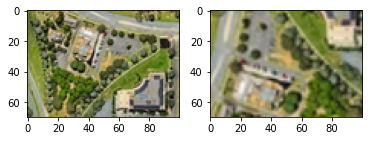

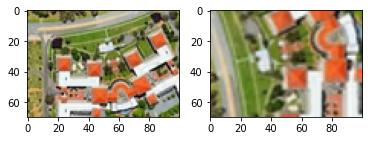

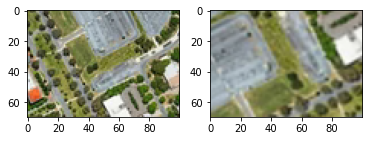

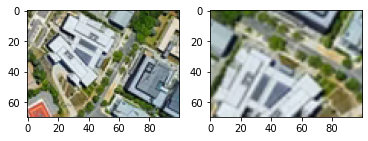

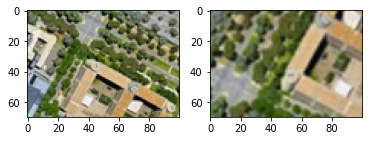

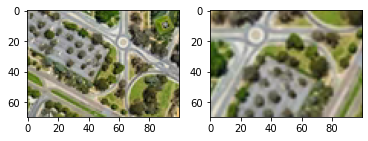

In [54]:
for i in range(len(tiles)):
    img = tiles[i]
    im2 = sized_tiles[i]
    rot = rotate(img, 90, reshape=False)
    rot = clipped_zoom(rot, 1.5)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[1].imshow(rot)

In [50]:
#convert single digit labels to one hots for classification 
img_data = [1,2,3,4,5,6,7,8,9,10]

print(len(img_data))
labelslist = range(len(img_data))
onehotslist = []
for label in labelslist:
    blank = np.zeros(len(labelslist))
    blank[label] = 1
    onehotslist.append(blank)
#print(onehotslist)
final_dict = {img_data[i]:onehotslist[i] for i in range(len(img_data))}
print(final_dict)

10
{1: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 3: array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 4: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 5: array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 6: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}
